# Altair-testing

In this notebook, we'll take a look at the [Altair](https://altair-viz.github.io/) data visualization library. Altair is a statistical visualisation library based on Vega-lite.

We'll still be looking at the [GMD metrics](https://github.com/chaoss/metrics/blob/master/2_Growth-Maturity-Decline.md)

In [1]:
# analysis modules
import pandas as pd

from elasticsearch_dsl import A, Q, Search

# utility and support modules
from new_functions import Query, Index, buckets_to_df, calculate_bmi
from derived_classes import PullRequests, Issues
from pprint import pprint
from datetime import datetime, timezone
from dateutil import parser, relativedelta

import altair as alt

In [2]:
# declare the necessary variables
github_data_source = "perceval_github"
git_data_source = "perceval_git"

github_index = Index(github_data_source)
git_index = Index(git_data_source)

start_date = datetime(2014, 8, 1)
start_date = start_date # "2014-08-01"
end_date = datetime(2018, 5, 22)
end_date = end_date

## Issue Resolution
Goal: Identify how effective the community is at addressing issues identified by community partcipants.

Name | Question | Implemented | Issue | PR | Visualisation 
--- | --- | --- | --- | --- | --- |
[Open Issues](https://github.com/chaoss/metrics/tree/master/activity-metrics/open-issues.md) | What is the number of open issues? | Yes | None | None | No
[Closed Issues](https://github.com/chaoss/metrics/tree/master/activity-metrics/closed-issues.md) | What is the number of closed issues? | Yes | None | None | No
[Issue Resolution Efficiency](https://github.com/chaoss/metrics/tree/master/activity-metrics/issue-resolution-efficiency.md) | What is the number of closed issues/number of abandoned issues? | Yes | [wg-gmd#5](https://github.com/chaoss/wg-gmd/issues/5) | None | No
[Open Issue Age](https://github.com/chaoss/metrics/tree/master/activity-metrics/open-issue-age.md) | What is the the age of open issues? | Yes | None | None | No
[First Response to Issue Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/first-response-to-issue-duration.md) | What is the duration of time for a first response to an issue? | No | [wg-gmd#8](https://github.com/chaoss/wg-gmd/issues/8) | None | No
[Closed Issue Resolution Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/closed-issue-resolution-duration.md) | What is the duration of time for issues to be resolved? | Yes | [wg-gmd#7](https://github.com/chaoss/wg-gmd/issues/7) | None | No

### Distribution of issues by month over time

Looking at a monthly distribution of the number of issues created each month and the number of issues closed each month.

In [3]:
opened_issues = Issues(github_index)
opened_issues_df = opened_issues.get_cardinality("id_in_repo").by_period().get_ts(True)

closed_issues = Issues(github_index)
closed_issues.is_closed()
closed_issues_df = closed_issues.get_cardinality("id_in_repo").by_period(field="closed_at").get_ts(True)
# here the closed_at date is the date when the issue was closed, which is logical when we are looking at distribution
# of issues created/closed per month

remaining_issues = Issues(github_index)
remaining_issues.is_open()
remaining_issues_df = remaining_issues.get_cardinality("id_in_repo").by_period().get_ts(True)

result_df = pd.concat([opened_issues_df, closed_issues_df, remaining_issues_df], axis=1, sort=False)
del result_df['unixtime']
result_df.columns = ['opened_issues', 'closed_issues', 'remaining_issues']

The reason that Altair differs from Plotly is that it uses [tidy data](http://nbviewer.jupyter.org/github/jfpuget/Tidy-Data/blob/master/Tidy-Data.ipynb) to create virtualizations.

In [4]:
# converting the messy data into tidy data

result_df = result_df.stack().reset_index()
result_df.columns = ['Date', 'issue_type', 'count']
result_df['Date'] = result_df['Date'].apply(datetime.isoformat)

**NOTE: All the visualizations here are interactive as we are appending the `interactive()` function at the end of them. You can zoom in and out of these graphs!!**
The fun part about Altair is that we can use a variety of formats to show the same data, some of them have been shown below:

As points

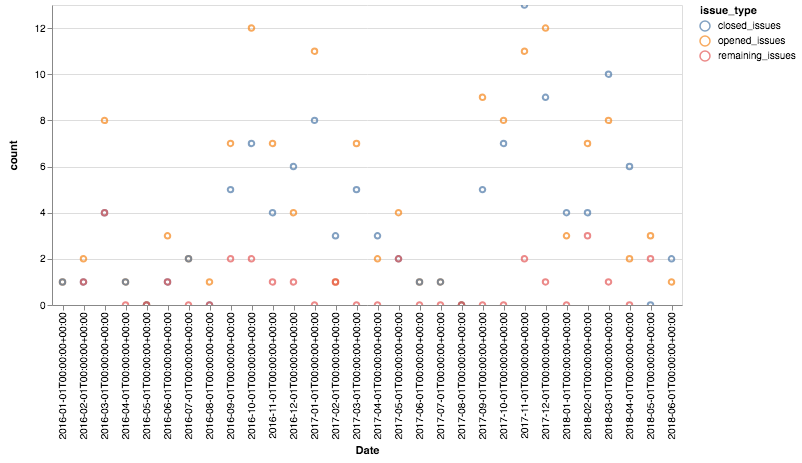

In [5]:
alt.Chart(result_df).mark_point().encode(
    x='Date',
    y='count',
    color='issue_type',
).interactive()

As a trail

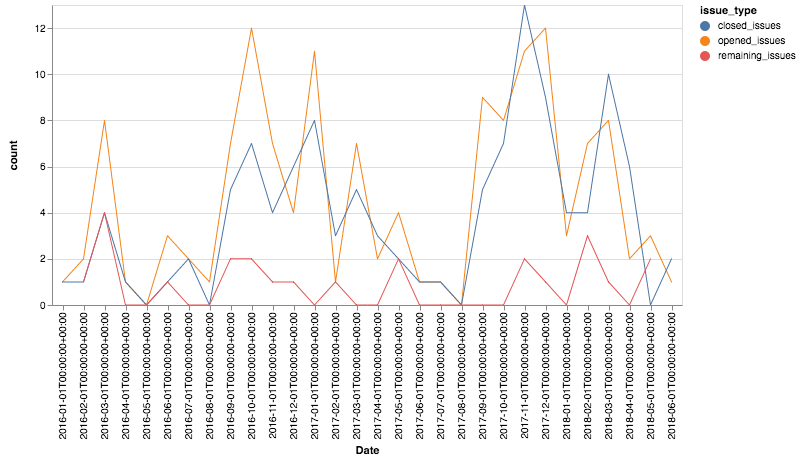

In [6]:
alt.Chart(result_df).mark_trail().encode(
    x='Date',
    y='count',
    color='issue_type',
).interactive()

As bars

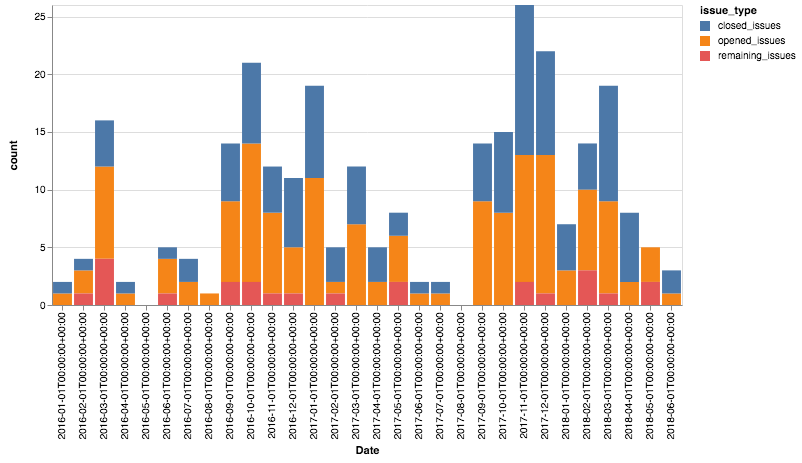

In [7]:
alt.Chart(result_df).mark_bar().encode(
    x='Date',
    y='count',
    color='issue_type',
).interactive()

As area

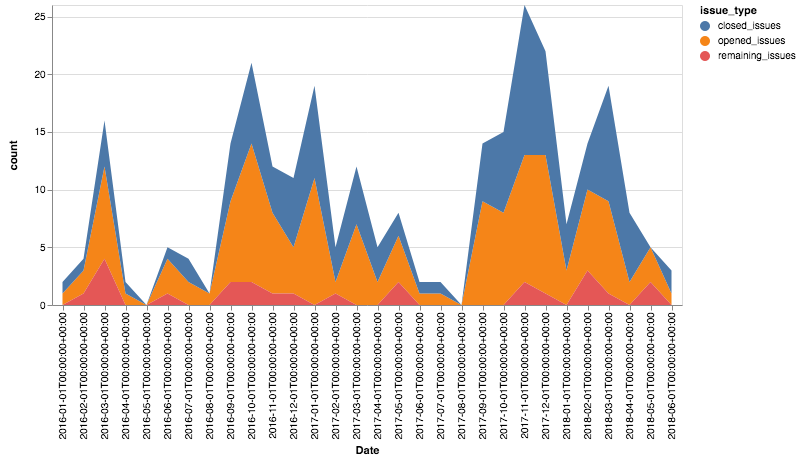

In [8]:
alt.Chart(result_df).mark_area().encode(
    x='Date',
    y='count',
    color='issue_type',
).interactive()

And to make this a horizontal graph, all we need to do is switch the axes!

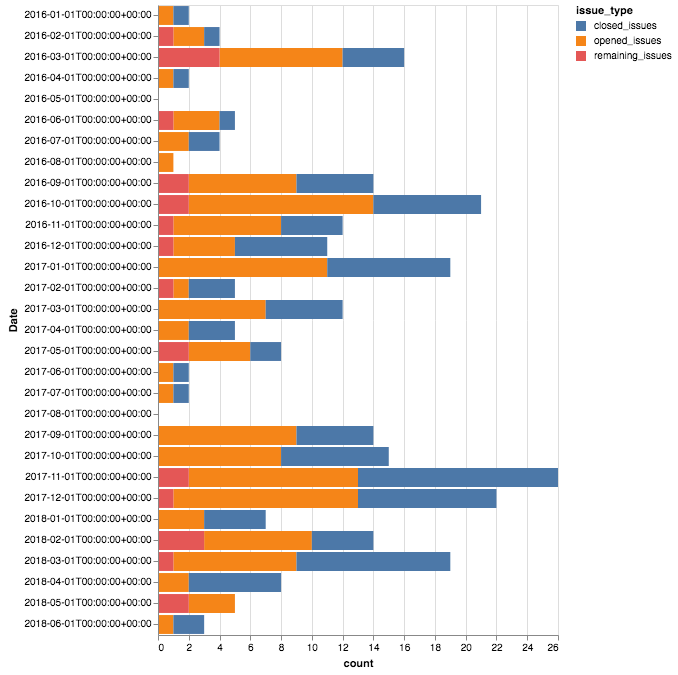

In [9]:
alt.Chart(result_df).mark_bar().encode(
    y='Date',
    x='count',
    color='issue_type',
).interactive()

We can also save this chart as a png file locally. More information can be found on [Altair's website](https://altair-viz.github.io/user_guide/saving_charts.html?highlight=png)

In [ ]:
chart = alt.Chart(result_df).mark_point().encode(
    x='Date',
    y='count',
    color='issue_type',
)

chart.save("images/altair-closed-opened-issues.png")

#### Closed and Opened issues by authors:

Here we are plotting the number of issues opened and closed by the respective authors.

In [10]:
closed_issues = Issues(github_index)
closed_issues.is_closed()
closed_by_authors = closed_issues.get_cardinality("id_in_repo").by_authors("author_name").fetch_aggregation_results()

opened_issues = Issues(github_index)
opened_by_authors = opened_issues.get_cardinality("id_in_repo").by_authors("author_name").fetch_aggregation_results()

closed_by_author_buckets = closed_by_authors['aggregations']['0']['buckets']
opened_by_author_buckets = opened_by_authors['aggregations']['0']['buckets']

closed_by_author_buckets_df = buckets_to_df(closed_by_author_buckets)
closed_by_author_buckets_df = closed_by_author_buckets_df.rename({"0":"closed_issues"}, axis='columns')
closed_by_author_buckets_df.drop("doc_count", axis=1)
#closed_by_author_buckets_df = closed_by_author_buckets_df.set_index("key", drop=False)


opened_by_author_buckets_df = buckets_to_df(opened_by_author_buckets)
opened_by_author_buckets_df = opened_by_author_buckets_df.rename({"0":"opened_issues"}, axis='columns')
opened_by_author_buckets_df.drop("doc_count",axis=1)

all_issues = pd.merge(opened_by_author_buckets_df, closed_by_author_buckets_df, on="key")
all_issues = all_issues.drop(['doc_count_x', 'doc_count_y'], axis=1)
all_issues = all_issues.set_index('key')

In [11]:
all_issues = all_issues.stack().reset_index()
all_issues.columns = ['key', 'issue_type', 'count']

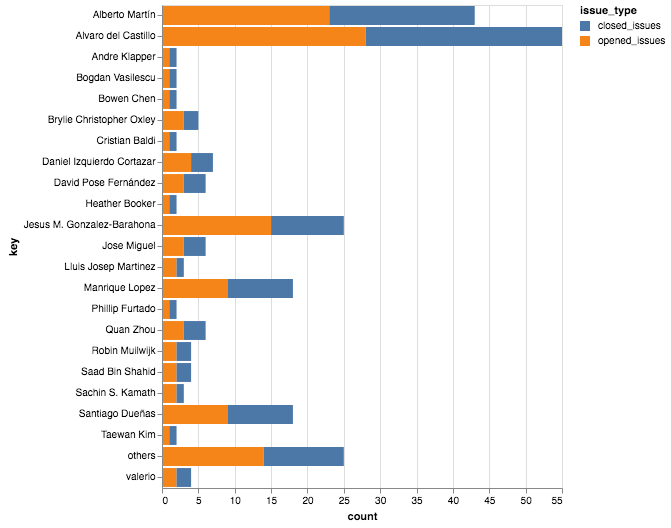

In [12]:
alt.Chart(all_issues).mark_bar().encode(
    x='count',
    y='key',
    color='issue_type'
).interactive()

<a id="closed_issues"></a>
### open issue age

As per the [discussion here](https://github.com/chaoss/metrics/blob/master/activity-metrics/open-issue-age.md), We'll calculate the percentile, mean, variance and create some visualisations for this metric.

In [13]:
issue = Issues(github_index)
issue.is_open()
percentiles = issue.get_percentiles("time_open_days").get_aggs()
print("Percentiles: ", percentiles)

issue.get_extended_stats("time_open_days")
extended_stats = issue.fetch_aggregation_results()['aggregations']['1']
pprint(extended_stats)

Percentiles:  516.5500030517578
{'avg': 462.02458477020264,
 'count': 24,
 'max': 851.4500122070312,
 'min': 35.63999938964844,
 'std_deviation': 284.39802592683293,
 'std_deviation_bounds': {'lower': -106.77146708346322,
                          'upper': 1030.8206366238685},
 'sum': 11088.590034484863,
 'sum_of_squares': 7064374.897995785,
 'variance': 80882.23715107953}


Here we plot the number of issues that are still open using bar graphs.

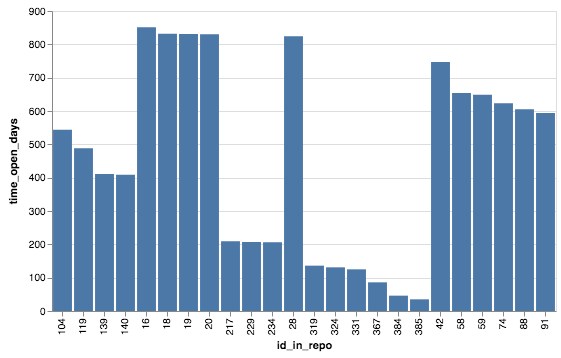

In [14]:
time_open_days_issues = Issues(github_index)
time_open_days_issues.is_open()
time_open_days_df = time_open_days_issues.fetch_results_from_source('time_open_days', 'id_in_repo', dataframe=True)
time_open_days_df['time_open_days'] = time_open_days_df['time_open_days'].apply(int)

time_open_days_df = time_open_days_df.sort_values(by="time_open_days")
alt.Chart(time_open_days_df).mark_bar().encode(
    x="id_in_repo",
    y='time_open_days'
)

### Closed issue resolution duration (Time to resolution of closed issue)

For Closed Issue resolution duration, we'll look at the the max_val(99th percentile), min_val(1st percentile), q1(25th percentile), q3(75th percentile) and the median value. We'll plot a simple [boxplot](https://altair-viz.github.io/gallery/boxplot_max_min.html) using the above values

In [15]:
closed_issues = Issues(github_index)
closed_issues.is_closed()

closed_issues.get_extended_stats("time_to_close_days")
extended_stats = closed_issues.fetch_aggregation_results()['aggregations']['0']
pprint(extended_stats)

{'avg': 30.83017426458714,
 'count': 115,
 'max': 582.3300170898438,
 'min': 0.0,
 'std_deviation': 92.63210085425231,
 'std_deviation_bounds': {'lower': -154.4340274439175,
                          'upper': 216.09437597309176},
 'sum': 3545.470040427521,
 'sum_of_squares': 1096088.661693576,
 'variance': 8580.706108672372}


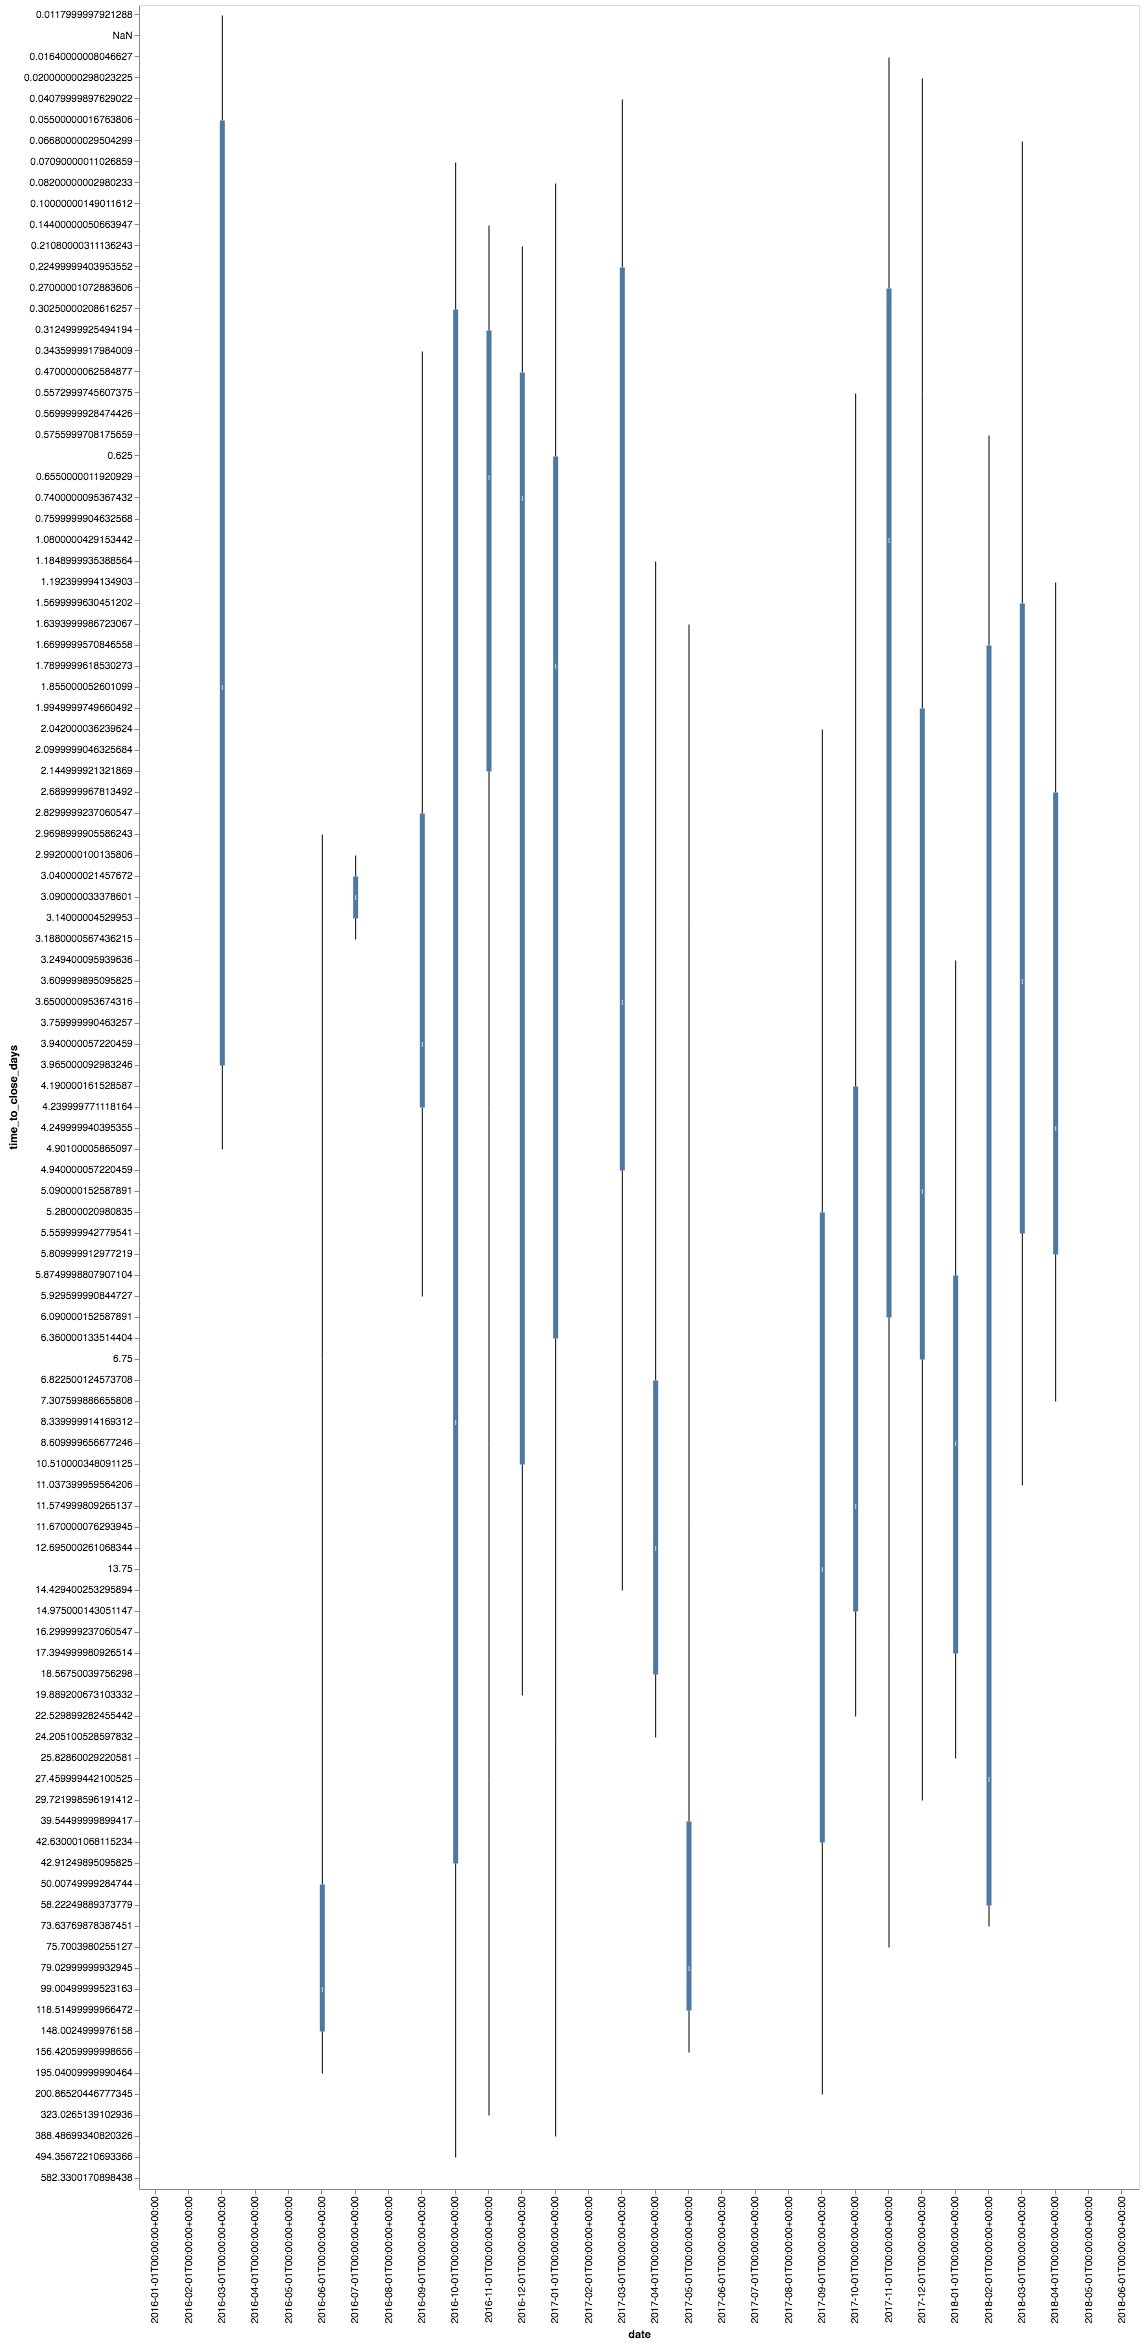

In [16]:
closed_issues.get_percentiles("time_to_close_days", percents=[25.0]).by_period(period="month")
closed_issues.get_percentiles("time_to_close_days", percents=[75.0]).by_period(period="month")
closed_issues.get_percentiles("time_to_close_days", percents=[1.0]).by_period(period="month")
closed_issues.get_percentiles("time_to_close_days", percents=[99.0]).by_period(period="month")
closed_issues.get_percentiles("time_to_close_days", percents=[50.0]).by_period(period="month")
response = closed_issues.fetch_aggregation_results()['aggregations']['1']['buckets']

ls = []
for item in response:
    temp={}
    temp['date'] = parser.parse(item['key_as_string']).isoformat()
    temp['percentile_25'] = item['0']['values']['25.0']
    temp['percentile_75'] = item['1']['values']['75.0']
    temp['min_val'] = item['2']['values']['1.0']
    temp['max_val'] = item['3']['values']['99.0']
    temp['average'] = item['4']['values']['50.0']
    ls.append(temp)

closed_issue_resolution_duration_df = pd.DataFrame(ls)

# Compose each layer individually
lower_plot = alt.Chart(closed_issue_resolution_duration_df).mark_rule().encode(
    y=alt.Y("min_val", axis=alt.Axis(title="time_to_close_days")),
    y2="percentile_25",
    x='date'
)

middle_plot = alt.Chart(closed_issue_resolution_duration_df).mark_bar(size=5.0).encode(
    y="percentile_25",
    y2="percentile_75",
    x='date'
)

upper_plot = alt.Chart(closed_issue_resolution_duration_df).mark_rule().encode(
    y="max_val",
    y2="percentile_75",
    x='date'
)

middle_tick = alt.Chart(closed_issue_resolution_duration_df).mark_tick(
    color='white',
    size=5.0
).encode(
    y='average',
    x='date',
)

(lower_plot + middle_plot + upper_plot + middle_tick).interactive().properties(width=1000)

## Code Development
Goal: Identify how effective the community is at merging new code into the codebase.

Name | Question | Implemented | Issue | PR
--- | --- | --- | --- | --- |
[Code Commits](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-commits.md) | What is the number of code commits? | Yes | None | None
[Lines of Code Changed](https://github.com/chaoss/metrics/tree/master/activity-metrics/lines-of-code-changed.md) | What is the number of lines of code changed? | Yes | None | None
[Code Reviews](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-reviews.md) | What is the number of code reviews?
[Code Merge Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-merge-duration.md) | What is the duration of time between code merge request and code commit?
[Code Review Efficiency](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-review-efficiency.md) | What is the number of merged code changes/number of abandoned code change requests?
[Maintainer Response to Merge Request Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/maintainer-response-to-merge-request-duration.md) | What is the duration of time for a maintainer to make a first response to a code merge request?
[Code Review Iteration](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-review-iteration.md) | What is the number of iterations that occur before a merge request is accepted or declined?
[Forks](https://github.com/chaoss/metrics/tree/master/activity-metrics/forks.md) | Forks are a concept in distributed version control systems like GitHub. It is a proxy for the approximate number of developers who have taken a shot at building and deploying the codebase *for development*.
[Pull Requests Open](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-requests-open.md) | Number of open pull requests. | Yes | None | None | 
[Pull Requests Closed](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-requests-made-closed.md) | Number of closed pull requests. | Yes | None | None |
[Pull Request Comment Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-requests-comment-duration.md) | The difference between the timestamp of the pull request creation date and the most recent comment on the pull request.
[Pull Request Comment Diversity](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-requests-comment-diversity.md) | Number of each people discussing each pull request.
[Pull Request Comments](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-request-comments.md) | Number of comments on each pull request. 


### code commits

**NOTE:** HERE THE INDEX WILL HAVE TO BE CHANGED

In [17]:
commits = Query(git_index)
commits.get_cardinality("hash")
total_commits = commits.get_aggs()
print("total commits: ", total_commits)

all_commits = commits.fetch_results_from_source("hash", "commit_date")

total commits:  1204


When you go to the [perceval github repo](https://github.com/chaoss/grimoirelab-perceval), you'll see that actually 1182 commit are present. That maybe because of some empty commit messages. 

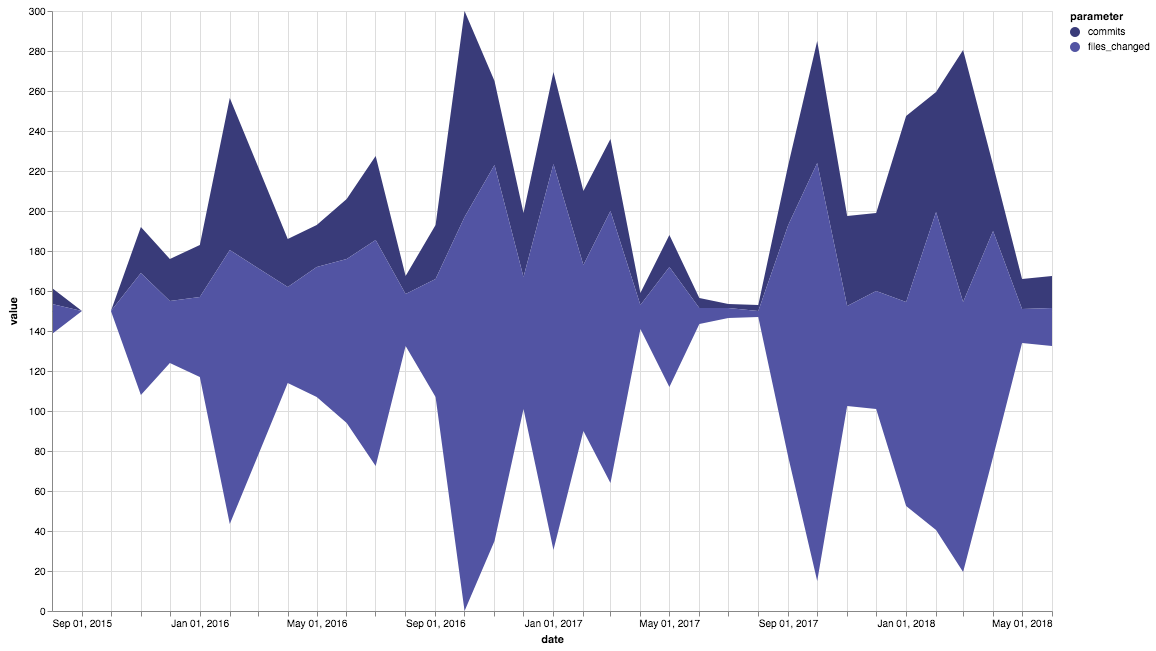

In [18]:
contributors = Query(git_index)

commits_per_month_df = commits.get_cardinality("hash").by_period(period="month").get_ts(dataframe=True)

#lines_changed_per_month_df = contributors.get_sum("lines_changed").by_period(period="month").get_ts(dataframe=True)
#print(contributors.search.to_dict())
#print(contributors.child_agg_counter_dict)

files_changed_per_month_df = contributors.get_sum("files").by_period(period="month").get_ts(dataframe=True)
#print(contributors.search.to_dict())

all_metrics_df = pd.concat([commits_per_month_df, files_changed_per_month_df], axis=1, sort=False) 
del all_metrics_df['unixtime']
all_metrics_df.columns = ['commits', 'files_changed']

all_metrics_df = all_metrics_df.stack().reset_index()
all_metrics_df.columns = ['date', 'parameter', 'value']
all_metrics_df['date'] = all_metrics_df['date'].apply(datetime.isoformat)

alt.Chart(all_metrics_df).mark_area().encode(
    alt.X('date:T'),
    alt.Y('value:Q', stack='center'),
    alt.Color('parameter:N',
        scale=alt.Scale(scheme='category20b')
    )
).interactive().properties(
    width=1000,
    height=600
)

This here, is a [stream graph](https://altair-viz.github.io/gallery/streamgraph.html), we can use this to compare values of different metrics. 

## Community Growth
Goal: Identify the size of the project community and whether it's growing, shrinking, or staying the same.

Name | Question | Implemented | Issue | PR
--- | --- | --- | --- | --- |
[Contributors](https://github.com/chaoss/metrics/tree/master/activity-metrics/contributors.md) | What is the number of contributors? | Yes | None | None
[New Contributors](https://github.com/chaoss/metrics/tree/master/activity-metrics/new-contributors.md) | What is the number of new contributors? | Yes | None | None
[Contributing Organizations](https://github.com/chaoss/metrics/tree/master/activity-metrics/contributing-organizations.md) | What is the number of contributing organizations? | Yes | None | None
[New Contributing Organizations](https://github.com/chaoss/metrics/tree/master/activity-metrics/new-contributing-organizations.md) | What is the number of new contributing organizations?
[Sub-Projects](https://github.com/chaoss/metrics/tree/master/activity-metrics/sub-projects.md) | What is the number of sub-projects?

### Number of contributors

Here, we are plotting the changes to the project by the authors seggregated by years.

In [23]:
contributors = Query(git_index)

author_contributions_by_year = []
years = ["2015", "2016", "2017", "2018"]
for year in years:
    temp_df = None
    contributors.since(parser.parse(year+"-01-01")).until(parser.parse(year+"-12-31")).get_sum("lines_changed").by_authors("author_name")
    contributors.get_sum("lines_added").by_authors("author_name")
    temp_df = buckets_to_df(contributors.get_sum("lines_removed").by_authors("author_name").fetch_aggregation_results()['aggregations']['0']['buckets'])
    del temp_df['doc_count']
    temp_df.columns = ["lines_changed", "lines_added", "lines_removed", "author"]
    temp_df = temp_df.set_index("author")
    temp_df = temp_df.stack().reset_index()
    temp_df.columns = ['authors', 'parameter', 'value']
    temp_df['year'] = year
    author_contributions_by_year.append(temp_df)

author_contributions_by_year_df = pd.concat(author_contributions_by_year)

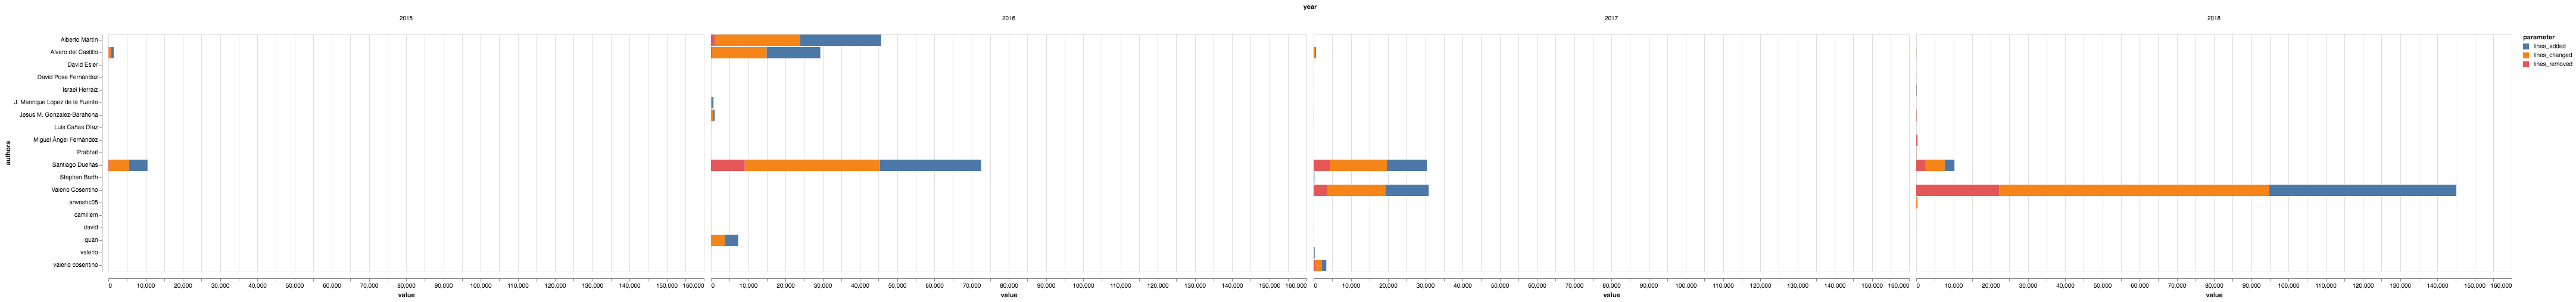

In [20]:
alt.Chart(author_contributions_by_year_df).mark_bar().encode(
    column='year',
    x='value',
    y='authors',
    color='parameter'
).properties(
    width=1000
)

And finally, we'll plot the corelation between the time open days and time to close days. Since for closed issues, it's one in the same thing, we can still use this technique to show the correlatin between different metrics.

In [21]:
issues = Issues(github_index)
pull_requests = PullRequests(github_index)

issues_df = issues.fetch_results_from_source('time_open_days', 'time_to_close_days', dataframe=True)
issues_df['type'] = "issue"
pull_requests_df = pull_requests.fetch_results_from_source('time_open_days', 'time_to_close_days', dataframe=True)
pull_requests_df['type'] = "pull_request"

issues_and_prs_df = pd.concat([issues_df, pull_requests_df]).fillna(0)

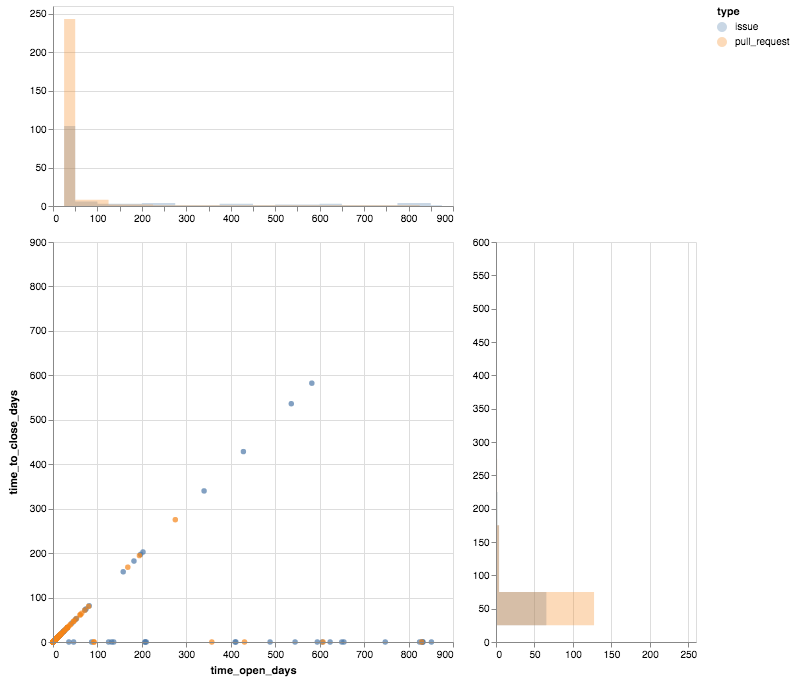

In [22]:
xscale = alt.Scale(domain=(0.0, 900.0))
yscale = alt.Scale(domain=(0.0, 900.0))

area_args = {'opacity': .3, 'interpolate': 'step'}
blank_axis = alt.Axis(title='')

points = alt.Chart(issues_and_prs_df).mark_circle().encode(
    alt.X('time_open_days', scale=xscale),
    alt.Y('time_to_close_days', scale=yscale),
    color='type',
).properties(width=400, height=400)

top_hist = alt.Chart(issues_and_prs_df).mark_area(**area_args).encode(
    alt.X('time_open_days:Q',
          # when using bins, the axis scale is set through
          # the bin extent, so we do not specify the scale here
          # (which would be ignored anyway)
          bin=alt.Bin(maxbins=20, extent=xscale.domain),
          stack=None,
          axis=blank_axis,
         ),
    alt.Y('count()', stack=None, axis=blank_axis),
    alt.Color('type:N'),
).properties(height=200, width=400)

right_hist = alt.Chart(issues_and_prs_df).mark_area(**area_args).encode(
    alt.Y('time_to_close_days:Q',
          bin=alt.Bin(maxbins=20, extent=yscale.domain),
          stack=None,
          axis=blank_axis,
         ),
    alt.X('count()', stack=None, axis=blank_axis),
    alt.Color('type:N'),
).properties(width=200, height=400)

top_hist & (points | right_hist)

The points on the x axis represent still open issues and PRs. We can create similar graphs for time_to_first_attention and other metrics but we might have to normalize them first!